## Load Dependancies / Libraries

In [58]:
import copy

import pandas as pd
import numpy as np

import psycopg2 as pg
import pandas.io.sql as psql
from psycopg2.extensions import ISOLATION_LEVEL_AUTOCOMMIT
from sqlalchemy import create_engine
from sqlalchemy import inspect
import config 

import seaborn as sns
import matplotlib.pyplot as plt

from numpy import where
from pprint import pprint
from scipy import stats
from collections import Counter

from xgboost import XGBClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import MinMaxScaler
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline

from sklearn.model_selection import train_test_split, GridSearchCV, \
RandomizedSearchCV, StratifiedKFold, RepeatedStratifiedKFold, cross_val_score

from sklearn.feature_selection import SelectFromModel
from sklearn.metrics import make_scorer, recall_score, confusion_matrix, \
precision_score, f1_score, accuracy_score, classification_report


## Read Data From PostgreSQL DB

In [44]:
# Conncet to postgresql dataBase table
protocol = 'postgresql'
username = 'postgres'
password = config.password
host = 'localhost'
port = 5432
database_name = 'Project4_db'

pg_connection = f'{protocol}://{username}:{password}@{host}:{port}/{database_name}'

In [45]:
#Create DataFrame from SQL table 
pg_connection = f'{protocol}://{username}:{password}@{host}:{port}/{database_name}'
conn = pg.connect(pg_connection)
raw_ibm_df = psql.read_sql('SELECT * FROM ibm_employee_data', conn)

# Display all the DataFrame Columns 
pd.options.display.max_columns = None
display(raw_ibm_df)

,age,attrition,businesstravel,dailyrate,department,distancefromhome,education,educationfield,employeecount,employeenumber,environmentsatisfaction,gender,hourlyrate,jobinvolvement,joblevel,jobrole,jobsatisfaction,maritalstatus,monthlyincome,monthlyrate,numcompaniesworked,over18,overtime,percentsalaryhike,performancerating,relationshipsatisfaction,standardhours,stockoptionlevel,totalworkingyears,trainingtimeslastyear,worklifebalance,yearsatcompany,yearsincurrentrole,yearssincelastpromotion,yearswithcurrmanager
0,41,Yes,Travel_Rarely,1102,Sales,1,2,Life Sciences,1,1,2,Female,94,3,2,Sales Executive,4,Single,5993,19479,8,Y,Yes,11,3,1,80,0,8,0,1,6,4,0,5
1,49,No,Travel_Frequently,279,Research & Development,8,1,Life Sciences,1,2,3,Male,61,2,2,Research Scientist,2,Married,5130,24907,1,Y,No,23,4,4,80,1,10,3,3,10,7,1,7
2,37,Yes,Travel_Rarely,1373,Research & Development,2,2,Other,1,4,4,Male,92,2,1,Laboratory Technician,3,Single,2090,2396,6,Y,Yes,15,3,2,80,0,7,3,3,0,0,0,0
3,33,No,Travel_Frequently,1392,Research & Development,3,4,Life Sciences,1,5,4,Female,56,3,1,Research Scientist,3,Married,2909,23159,1,Y,Yes,11,3,3,80,0,8,3,3,8,7,3,0
4,27,No,Travel_Rarely,591,Research & Development,2,1,Medical,1,7,1,Male,40,3,1,Laboratory Technician,2,Married,3468,16632,9,Y,No,12,3,4,80,1,6,3,3,2,2,2,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1465,36,No,Travel_Frequently,884,Research & Development,23,2,Medical,1,2061,3,Male,41,4,2,Laboratory Technician,4,Married,2571,12290,4,Y,No,17,3,3,80,1,17,3,3,5,2,0,3
1466,39,No,Travel_Rarely,613,Research & Development,6,1,Medical,1,2062,4,Male,42,2,3,Healthcare Representative,1,Married,9991,21457,4,Y,No,15,3,1,80,1,9,5,3,7,7,1,7
1467,27,No,Travel_Rarely,155,Research & Development,4,3,Life Sciences,1,2064,2,Male,87,4,2,Manufacturing Director,2,Married,6142,5174,1,Y,Yes,20,4,2,80,1,6,0,3,6,2,0,3
1468,49,No,Travel_Frequently,1023,Sales,2,3,Medical,1,2065,4,Male,63,2,2,Sales Executive,2,Married,5390,13243,2,Y,No,14,3,4,80,0,17,3,2,9,6,0,8


In [46]:
raw_ibm_df.columns

Index(['age', 'attrition', 'businesstravel', 'dailyrate', 'department',
       'distancefromhome', 'education', 'educationfield', 'employeecount',
       'employeenumber', 'environmentsatisfaction', 'gender', 'hourlyrate',
       'jobinvolvement', 'joblevel', 'jobrole', 'jobsatisfaction',
       'maritalstatus', 'monthlyincome', 'monthlyrate', 'numcompaniesworked',
       'over18', 'overtime', 'percentsalaryhike', 'performancerating',
       'relationshipsatisfaction', 'standardhours', 'stockoptionlevel',
       'totalworkingyears', 'trainingtimeslastyear', 'worklifebalance',
       'yearsatcompany', 'yearsincurrentrole', 'yearssincelastpromotion',
       'yearswithcurrmanager'],
      dtype='object')

In [49]:
df = raw_ibm_df.rename(columns = {'age' : 'Age', 
                                        'attrition' :'DailyRate', 
                                        'businesstravel' : 'BusinessTravel', 
                                        'dailyrate' : 'DailyRate', 
                                        'department' : 'Department',
                                        'distancefromhome' : 'DistanceFromHome', 
                                        'education' : 'Education', 
                                        'educationfield' : 'EducationField', 
                                        'employeecount' : 'EmployeeCount',
                                        'employeenumber' : 'EmployeeNumber', 
                                        'environmentsatisfaction' : 'EnvironmentSatisfaction', 
                                        'gender' : 'Gender', 
                                        'hourlyrate' : 'HourlyRate',
                                        'jobinvolvement' : 'JobInvolvement', 
                                        'joblevel' : 'JobLevel', 
                                        'jobrole' : 'JobRole', 
                                        'jobsatisfaction' : 'JobSatisfaction',
                                        'maritalstatus' : 'MaritalStatus', 
                                        'monthlyincome' : 'MonthlyIncome', 
                                        'monthlyrate' : 'MonthlyRate', 
                                        'numcompaniesworked' : 'NumCompaniesWorked',
                                        'over18' : 'Over18', 
                                        'overtime' : 'OverTime', 
                                        'percentsalaryhike' : 'PercentSalaryHike', 
                                        'performancerating' : 'PerformanceRating',
                                        'relationshipsatisfaction' : 'RelationshipSatisfaction', 
                                        'standardhours' : 'StandardHours', 
                                        'stockoptionlevel' : 'StockOptionLevel',
                                        'totalworkingyears' : 'TotalWorkingYears', 
                                        'trainingtimeslastyear' : 'TrainingTimesLastYear', 
                                        'worklifebalance' : 'WorkLifeBalance',
                                        'yearsatcompany' : 'YearsAtCompany', 
                                        'yearsincurrentrole': 'YearsInCurrentRole', 
                                        'yearssincelastpromotion' : 'YearsSinceLastPromotion',
                                        'yearswithcurrmanager' : 'YearsWithCurrManager'
})
display(df)


,Age,DailyRate,BusinessTravel,DailyRate,Department,DistanceFromHome,Education,EducationField,EmployeeCount,EmployeeNumber,EnvironmentSatisfaction,Gender,HourlyRate,JobInvolvement,JobLevel,JobRole,JobSatisfaction,MaritalStatus,MonthlyIncome,MonthlyRate,NumCompaniesWorked,Over18,OverTime,PercentSalaryHike,PerformanceRating,RelationshipSatisfaction,StandardHours,StockOptionLevel,TotalWorkingYears,TrainingTimesLastYear,WorkLifeBalance,YearsAtCompany,YearsInCurrentRole,YearsSinceLastPromotion,YearsWithCurrManager
0,41,Yes,Travel_Rarely,1102,Sales,1,2,Life Sciences,1,1,2,Female,94,3,2,Sales Executive,4,Single,5993,19479,8,Y,Yes,11,3,1,80,0,8,0,1,6,4,0,5
1,49,No,Travel_Frequently,279,Research & Development,8,1,Life Sciences,1,2,3,Male,61,2,2,Research Scientist,2,Married,5130,24907,1,Y,No,23,4,4,80,1,10,3,3,10,7,1,7
2,37,Yes,Travel_Rarely,1373,Research & Development,2,2,Other,1,4,4,Male,92,2,1,Laboratory Technician,3,Single,2090,2396,6,Y,Yes,15,3,2,80,0,7,3,3,0,0,0,0
3,33,No,Travel_Frequently,1392,Research & Development,3,4,Life Sciences,1,5,4,Female,56,3,1,Research Scientist,3,Married,2909,23159,1,Y,Yes,11,3,3,80,0,8,3,3,8,7,3,0
4,27,No,Travel_Rarely,591,Research & Development,2,1,Medical,1,7,1,Male,40,3,1,Laboratory Technician,2,Married,3468,16632,9,Y,No,12,3,4,80,1,6,3,3,2,2,2,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1465,36,No,Travel_Frequently,884,Research & Development,23,2,Medical,1,2061,3,Male,41,4,2,Laboratory Technician,4,Married,2571,12290,4,Y,No,17,3,3,80,1,17,3,3,5,2,0,3
1466,39,No,Travel_Rarely,613,Research & Development,6,1,Medical,1,2062,4,Male,42,2,3,Healthcare Representative,1,Married,9991,21457,4,Y,No,15,3,1,80,1,9,5,3,7,7,1,7
1467,27,No,Travel_Rarely,155,Research & Development,4,3,Life Sciences,1,2064,2,Male,87,4,2,Manufacturing Director,2,Married,6142,5174,1,Y,Yes,20,4,2,80,1,6,0,3,6,2,0,3
1468,49,No,Travel_Frequently,1023,Sales,2,3,Medical,1,2065,4,Male,63,2,2,Sales Executive,2,Married,5390,13243,2,Y,No,14,3,4,80,0,17,3,2,9,6,0,8


## Load, Inspect and Clean Data

In [6]:
# checking for null values
raw_ibm_df.isnull().sum()

age                         0
attrition                   0
businesstravel              0
dailyrate                   0
department                  0
distancefromhome            0
education                   0
educationfield              0
employeecount               0
employeenumber              0
environmentsatisfaction     0
gender                      0
hourlyrate                  0
jobinvolvement              0
joblevel                    0
jobrole                     0
jobsatisfaction             0
maritalstatus               0
monthlyincome               0
monthlyrate                 0
numcompaniesworked          0
over18                      0
overtime                    0
percentsalaryhike           0
performancerating           0
relationshipsatisfaction    0
standardhours               0
stockoptionlevel            0
totalworkingyears           0
trainingtimeslastyear       0
worklifebalance             0
yearsatcompany              0
yearsincurrentrole          0
yearssince

In [7]:
# checking number of uniques values per column
raw_ibm_df.nunique()

age                           43
attrition                      2
businesstravel                 3
dailyrate                    886
department                     3
distancefromhome              29
education                      5
educationfield                 6
employeecount                  1
employeenumber              1470
environmentsatisfaction        4
gender                         2
hourlyrate                    71
jobinvolvement                 4
joblevel                       5
jobrole                        9
jobsatisfaction                4
maritalstatus                  3
monthlyincome               1349
monthlyrate                 1427
numcompaniesworked            10
over18                         1
overtime                       2
percentsalaryhike             15
performancerating              2
relationshipsatisfaction       4
standardhours                  1
stockoptionlevel               4
totalworkingyears             40
trainingtimeslastyear          7
worklifeba

In [8]:
raw_ibm_df.describe()

,age,dailyrate,distancefromhome,education,employeecount,environmentsatisfaction,hourlyrate,jobinvolvement,joblevel,jobsatisfaction,monthlyincome,monthlyrate,numcompaniesworked,percentsalaryhike,performancerating,relationshipsatisfaction,standardhours,stockoptionlevel,totalworkingyears,trainingtimeslastyear,worklifebalance,yearsatcompany,yearsincurrentrole,yearssincelastpromotion,yearswithcurrmanager
count,1470.000000,1470.000000,1470.000000,1470.000000,1470.0,1470.000000,1470.000000,1470.000000,1470.000000,1470.000000,1470.000000,1470.000000,1470.000000,1470.000000,1470.000000,1470.000000,1470.0,1470.000000,1470.000000,1470.000000,1470.000000,1470.000000,1470.000000,1470.000000,1470.000000
mean,36.923810,802.485714,9.192517,2.912925,1.0,2.721769,65.891156,2.729932,2.063946,2.728571,6502.931293,14313.103401,2.693197,15.209524,3.153741,2.712245,80.0,0.793878,11.279592,2.799320,2.761224,7.008163,4.229252,2.187755,4.123129
std,9.135373,403.509100,8.106864,1.024165,0.0,1.093082,20.329428,0.711561,1.106940,1.102846,4707.956783,7117.786044,2.498009,3.659938,0.360824,1.081209,0.0,0.852077,7.780782,1.289271,0.706476,6.126525,3.623137,3.222430,3.568136
min,18.000000,102.000000,1.000000,1.000000,1.0,1.000000,30.000000,1.000000,1.000000,1.000000,1009.000000,2094.000000,0.000000,11.000000,3.000000,1.000000,80.0,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000
25%,30.000000,465.000000,2.000000,2.000000,1.0,2.000000,48.000000,2.000000,1.000000,2.000000,2911.000000,8047.000000,1.000000,12.000000,3.000000,2.000000,80.0,0.000000,6.000000,2.000000,2.000000,3.000000,2.000000,0.000000,2.000000
50%,36.000000,802.000000,7.000000,3.000000,1.0,3.000000,66.000000,3.000000,2.000000,3.000000,4919.000000,14235.500000,2.000000,14.000000,3.000000,3.000000,80.0,1.000000,10.000000,3.000000,3.000000,5.000000,3.000000,1.000000,3.000000
75%,43.000000,1157.000000,14.000000,4.000000,1.0,4.000000,83.750000,3.000000,3.000000,4.000000,8379.000000,20461.500000,4.000000,18.000000,3.000000,4.000000,80.0,1.000000,15.000000,3.000000,3.000000,9.000000,7.000000,3.000000,7.000000
max,60.000000,1499.000000,29.000000,5.000000,1.0,4.000000,100.000000,4.000000,5.000000,4.000000,19999.000000,26999.000000,9.000000,25.000000,4.000000,4.000000,80.0,3.000000,40.000000,6.000000,4.000000,40.000000,18.000000,15.000000,17.000000


In [9]:
# checking data types
raw_ibm_df.dtypes

age                          int64
attrition                   object
businesstravel              object
dailyrate                    int64
department                  object
distancefromhome             int64
education                    int64
educationfield              object
employeecount                int64
employeenumber              object
environmentsatisfaction      int64
gender                      object
hourlyrate                   int64
jobinvolvement               int64
joblevel                     int64
jobrole                     object
jobsatisfaction              int64
maritalstatus               object
monthlyincome                int64
monthlyrate                  int64
numcompaniesworked           int64
over18                      object
overtime                    object
percentsalaryhike            int64
performancerating            int64
relationshipsatisfaction     int64
standardhours                int64
stockoptionlevel             int64
totalworkingyears   

In [10]:
raw_ibm_df.count()

age                         1470
attrition                   1470
businesstravel              1470
dailyrate                   1470
department                  1470
distancefromhome            1470
education                   1470
educationfield              1470
employeecount               1470
employeenumber              1470
environmentsatisfaction     1470
gender                      1470
hourlyrate                  1470
jobinvolvement              1470
joblevel                    1470
jobrole                     1470
jobsatisfaction             1470
maritalstatus               1470
monthlyincome               1470
monthlyrate                 1470
numcompaniesworked          1470
over18                      1470
overtime                    1470
percentsalaryhike           1470
performancerating           1470
relationshipsatisfaction    1470
standardhours               1470
stockoptionlevel            1470
totalworkingyears           1470
trainingtimeslastyear       1470
worklifeba

In [11]:
# Drop null values
dropNA_ibm_df = raw_ibm_df.dropna()
print(dropNA_ibm_df.count())

age                         1470
attrition                   1470
businesstravel              1470
dailyrate                   1470
department                  1470
distancefromhome            1470
education                   1470
educationfield              1470
employeecount               1470
employeenumber              1470
environmentsatisfaction     1470
gender                      1470
hourlyrate                  1470
jobinvolvement              1470
joblevel                    1470
jobrole                     1470
jobsatisfaction             1470
maritalstatus               1470
monthlyincome               1470
monthlyrate                 1470
numcompaniesworked          1470
over18                      1470
overtime                    1470
percentsalaryhike           1470
performancerating           1470
relationshipsatisfaction    1470
standardhours               1470
stockoptionlevel            1470
totalworkingyears           1470
trainingtimeslastyear       1470
worklifeba

#### No N/A Values in the DataSet

In [12]:
dropdup_ibm_df = raw_ibm_df.drop_duplicates()
dropdup_ibm_df.count()

age                         1470
attrition                   1470
businesstravel              1470
dailyrate                   1470
department                  1470
distancefromhome            1470
education                   1470
educationfield              1470
employeecount               1470
employeenumber              1470
environmentsatisfaction     1470
gender                      1470
hourlyrate                  1470
jobinvolvement              1470
joblevel                    1470
jobrole                     1470
jobsatisfaction             1470
maritalstatus               1470
monthlyincome               1470
monthlyrate                 1470
numcompaniesworked          1470
over18                      1470
overtime                    1470
percentsalaryhike           1470
performancerating           1470
relationshipsatisfaction    1470
standardhours               1470
stockoptionlevel            1470
totalworkingyears           1470
trainingtimeslastyear       1470
worklifeba

#### No duplicates in the dataset

In [13]:
# Push cleaned DataFrame to a new CSV file
raw_ibm_df.to_csv("output/ibm_data_cleaned.csv",
                  encoding="utf-8", index=False, header=True)

## Data Anaylsis

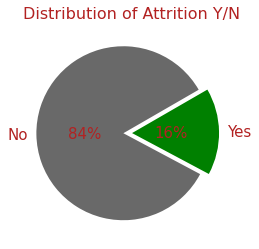

In [14]:
# Plot pie chart of ATTRITION is show if data is balanced "OR" imbalanced

raw_ibm_df['attrition'].value_counts(normalize=True).plot(kind='pie', pctdistance=0.45, autopct="%.0f%%", explode = (0.1, 0), startangle=30, colors = ['dimgrey', 'green'] , fontsize=15, textprops={'color':"firebrick"})

plt.title(("Distribution of Attrition Y/N"),fontsize=16, color = 'firebrick')

plt.xlabel("")
plt.ylabel("");

# save heatmap as .png file
plt.savefig('attrition_pie.png', dpi=300, bbox_inches='tight')

##### Note: I can be seen that the dataset has imbalanced data 84% to 16%

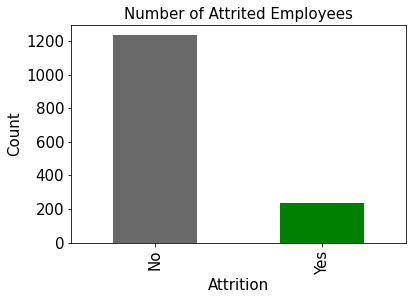

In [15]:
raw_ibm_df['attrition'].value_counts(normalize=False).plot(kind='bar', fontsize=15, color = ['dimgrey', 'green'])
plt.xlabel("Attrition", fontsize=15)
plt.ylabel("Count", fontsize=15)
plt.title('Number of Attrited Employees',fontsize=15);

TypeError: set_label() got an unexpected keyword argument 'rotation'

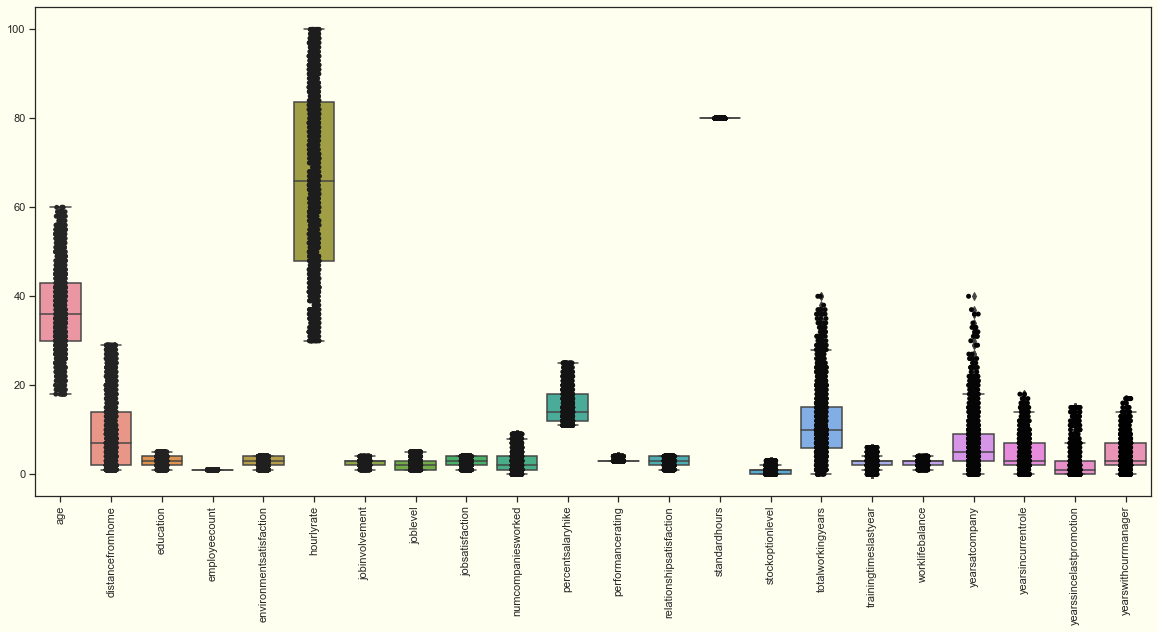

In [16]:
# Box plots for 
sns.set(
        style="ticks",                   # The 'ticks' style
        rc={"figure.figsize": (20, 9),      # width = 6, height = 9
            "figure.facecolor": "ivory",  # Figure colour
            "axes.facecolor": "ivory"})  # Axes colour
b1 = sns.boxplot(data = raw_ibm_df[['age', 
                            'distancefromhome', 
                            'education', 
                            'employeecount',
                            'environmentsatisfaction', 
                            'hourlyrate',
                            'jobinvolvement', 
                            'joblevel', 
                            'jobsatisfaction',
                            'numcompaniesworked',
                            'percentsalaryhike', 
                            'performancerating',
                            'relationshipsatisfaction', 
                            'standardhours', 
                            'stockoptionlevel',
                            'totalworkingyears', 
                            'trainingtimeslastyear', 
                            'worklifebalance',
                            'yearsatcompany', 
                            'yearsincurrentrole', 
                            'yearssincelastpromotion',
                            'yearswithcurrmanager']]) 
b1 = sns.stripplot(data = raw_ibm_df[['age', 
                            'distancefromhome', 
                            'education', 
                            'employeecount',
                            'environmentsatisfaction', 
                            'hourlyrate',
                            'jobinvolvement', 
                            'joblevel', 
                            'jobsatisfaction',
                            'numcompaniesworked',
                            'percentsalaryhike', 
                            'performancerating',
                            'relationshipsatisfaction', 
                            'standardhours', 
                            'stockoptionlevel',
                            'totalworkingyears', 
                            'trainingtimeslastyear', 
                            'worklifebalance',
                            'yearsatcompany', 
                            'yearsincurrentrole', 
                            'yearssincelastpromotion',
                            'yearswithcurrmanager']], palette='dark:black')
plt.setp(b1.get_xticklabels(), rotation=90)
# Set the x axis and font size
b1.set_label(raw_ibm_df, rotation = 90)
# Set the plot title with the pval variable and font size
b1.set_title("TITLE", fontsize = 16)
# Remove axis spines
sns.despine(offset = 5, trim = True)

b1.get_figure();

In [ ]:
# Boxplots for employeenumber', 'dailyrate'
sns.set(
        style="ticks",                   # The 'ticks' style
        rc={"figure.figsize": (6, 9),      # width = 6, height = 9
            "figure.facecolor": "ivory",  # Figure colour
            "axes.facecolor": "ivory"})  # Axes colour
b2 = sns.boxplot(data = raw_ibm_df[['employeenumber', 'dailyrate']])
b2 = sns.stripplot(data = raw_ibm_df[['employeenumber', 'dailyrate']], palette='dark:black')
b2.get_figure();



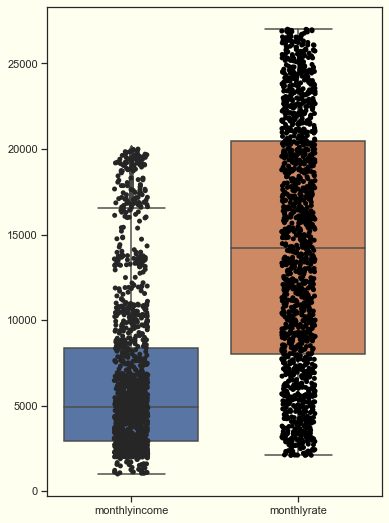

In [17]:
# Boxplots for 'monthlyincome', 'monthlyrate'
sns.set(
        style="ticks",                   # The 'ticks' style
        rc={"figure.figsize": (6, 9),      # width = 6, height = 9
            "figure.facecolor": "ivory",  # Figure colour
            "axes.facecolor": "ivory"})  # Axes colour
b3 = sns.boxplot(data = raw_ibm_df[['monthlyincome', 'monthlyrate']])
b3 = sns.stripplot(data = raw_ibm_df[['monthlyincome', 'monthlyrate']], palette='dark:black')
b3.get_figure();

## Prepare the dataset for modeling

In [18]:
raw_ibm_df.dtypes

age                          int64
attrition                   object
businesstravel              object
dailyrate                    int64
department                  object
distancefromhome             int64
education                    int64
educationfield              object
employeecount                int64
employeenumber              object
environmentsatisfaction      int64
gender                      object
hourlyrate                   int64
jobinvolvement               int64
joblevel                     int64
jobrole                     object
jobsatisfaction              int64
maritalstatus               object
monthlyincome                int64
monthlyrate                  int64
numcompaniesworked           int64
over18                      object
overtime                    object
percentsalaryhike            int64
performancerating            int64
relationshipsatisfaction     int64
standardhours                int64
stockoptionlevel             int64
totalworkingyears   

In [19]:
ibm_df = raw_ibm_df.drop(['employeenumber'], axis = 1)

In [20]:
ibm_df_1 = ibm_df.copy()
ibm_df_1['attrition'] = ibm_df_1['attrition'].apply(lambda x: 0 if x=='No' else 1)
ibm_df_1['gender'] = ibm_df_1['gender'].apply(lambda x: 0 if x=='Male' else 1)
ibm_df_1['overtime'] = ibm_df_1['overtime'].apply(lambda x: 0 if x=='No' else 1)
ibm_df_1['over18'] = ibm_df_1['over18'].apply(lambda x: 0 if x=='No' else 1)

BusinessTravel_map = {'Non-Travel':0, 'Travel_Rarely':1, 'Travel_Frequently':2}
ibm_df_1['businesstravel'] = ibm_df_1['businesstravel'].map(BusinessTravel_map)

MaritalStatus_map = {'Single':0, 'Divorced':1, 'Married':2}
ibm_df_1['maritalstatus'] = ibm_df_1['maritalstatus'].map(MaritalStatus_map)

EducationField_map = {'Other':0, 'Life Sciences':1, 'Medical':2, 'Marketing':3, 'Technical Degree':4,
                     'Human Resources':5}
ibm_df_1['educationfield'] = ibm_df_1['educationfield'].map(EducationField_map)

JobRole_map = {'Sales Executive':0,'Sales Representative':1,'Laboratory Technician':2,'Manufacturing Director':3,
              'Healthcare Representative':4,'Manager':5,'Research Scientist':6,'Research Director':7,'Human Resources':8}
ibm_df_1['jobrole'] = ibm_df_1['jobrole'].map(JobRole_map)

Department_map = {'Sales':0, 'Research & Development':1, 'Human Resources':2}
ibm_df_1['department'] = ibm_df_1['department'].map(Department_map)
ibm_df_1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1470 entries, 0 to 1469
Data columns (total 34 columns):
 #   Column                    Non-Null Count  Dtype
---  ------                    --------------  -----
 0   age                       1470 non-null   int64
 1   attrition                 1470 non-null   int64
 2   businesstravel            1470 non-null   int64
 3   dailyrate                 1470 non-null   int64
 4   department                1470 non-null   int64
 5   distancefromhome          1470 non-null   int64
 6   education                 1470 non-null   int64
 7   educationfield            1470 non-null   int64
 8   employeecount             1470 non-null   int64
 9   environmentsatisfaction   1470 non-null   int64
 10  gender                    1470 non-null   int64
 11  hourlyrate                1470 non-null   int64
 12  jobinvolvement            1470 non-null   int64
 13  joblevel                  1470 non-null   int64
 14  jobrole                   1470 non-null 

In [21]:
ibm_df_1.over18.value_counts()

1    1470
Name: over18, dtype: int64

In [22]:
ibm_df_1.corr()

,age,attrition,businesstravel,dailyrate,department,distancefromhome,education,educationfield,employeecount,environmentsatisfaction,gender,hourlyrate,jobinvolvement,joblevel,jobrole,jobsatisfaction,maritalstatus,monthlyincome,monthlyrate,numcompaniesworked,over18,overtime,percentsalaryhike,performancerating,relationshipsatisfaction,standardhours,stockoptionlevel,totalworkingyears,trainingtimeslastyear,worklifebalance,yearsatcompany,yearsincurrentrole,yearssincelastpromotion,yearswithcurrmanager
age,1.000000,-0.159205,-0.011807,0.010661,0.031882,-0.001686,0.208034,0.006751,NaN,0.010146,0.036311,0.024287,0.029820,0.509604,0.112757,-0.004892,0.111831,0.497855,0.028051,0.299635,NaN,0.028062,0.003634,0.001904,0.053535,NaN,0.037510,0.680381,-0.019621,-0.021490,0.311309,0.212901,0.216513,0.202089
attrition,-0.159205,1.000000,0.127006,-0.056652,-0.063991,0.077924,-0.031373,0.086359,NaN,-0.103369,-0.029453,-0.006846,-0.130016,-0.169105,-0.098921,-0.103481,-0.145985,-0.159840,0.015170,0.043494,NaN,0.246118,-0.013478,0.002889,-0.045872,NaN,-0.137145,-0.171063,-0.059478,-0.063939,-0.134392,-0.160545,-0.033019,-0.156199
businesstravel,-0.011807,0.127006,1.000000,-0.015539,0.002640,-0.009696,-0.008670,-0.018430,NaN,-0.011310,0.044896,-0.004164,0.029300,-0.011696,-0.003851,0.008666,-0.011068,-0.013450,-0.008440,-0.030743,NaN,0.042752,-0.025727,0.001683,0.008926,NaN,-0.028257,0.007972,0.016357,0.004209,0.005212,-0.005336,0.005222,-0.000229
dailyrate,0.010661,-0.056652,-0.015539,1.000000,-0.007109,-0.004985,-0.016806,-0.017943,NaN,0.018355,0.011716,0.023381,0.046135,0.002966,-0.006912,0.030571,0.063512,0.007707,-0.032182,0.038153,NaN,0.009135,0.022704,0.000473,0.007846,NaN,0.042143,0.014515,0.002453,-0.037848,-0.034055,0.009932,-0.033229,-0.026363
department,0.031882,-0.063991,0.002640,-0.007109,1.000000,-0.017225,-0.007996,-0.057197,NaN,0.019395,-0.041583,0.004144,0.024586,-0.101963,0.750143,-0.021001,0.030927,-0.053130,-0.023642,0.035882,NaN,-0.007481,0.007840,0.024604,0.022414,NaN,0.012193,0.015762,-0.036875,-0.026383,-0.022920,-0.056315,-0.040061,-0.034282
distancefromhome,-0.001686,0.077924,-0.009696,-0.004985,-0.017225,1.000000,0.021042,0.016556,NaN,-0.016075,0.001851,0.031131,0.008783,0.005303,-0.041934,-0.003669,0.031992,-0.017014,0.027473,-0.029251,NaN,0.025514,0.040235,0.027110,0.006557,NaN,0.044872,0.004628,-0.036942,-0.026556,0.009508,0.018845,0.010029,0.014406
education,0.208034,-0.031373,-0.008670,-0.016806,-0.007996,0.021042,1.000000,-0.005477,NaN,-0.027128,0.016547,0.016775,0.042438,0.101589,0.024950,-0.011296,-0.003299,0.094961,-0.026084,0.126317,NaN,-0.020322,-0.011111,-0.024539,-0.009118,NaN,0.018422,0.148280,-0.025100,0.009819,0.069114,0.060236,0.054254,0.069065
educationfield,0.006751,0.086359,-0.018430,-0.017943,-0.057197,0.016556,-0.005477,1.000000,NaN,-0.003926,0.006747,-0.004908,-0.003303,0.012174,-0.032052,-0.048967,0.040575,0.012022,0.001295,0.006959,NaN,-0.007777,-0.048057,-0.032419,0.024609,NaN,0.026710,0.001367,0.003143,0.019488,0.009311,0.001687,0.012719,0.001673
employeecount,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
environmentsatisfaction,0.010146,-0.103369,-0.011310,0.018355,0.019395,-0.016075,-0.027128,-0.003926,NaN,1.000000,-0.000508,-0.049857,-0.008278,0.001212,-0.009234,-0.006784,-0.017527,-0.006259,0.037600,0.012594,NaN,0.070132,-0.031701,-0.029548,0.007665,NaN,0.003432,-0.002693,-0.019359,0.027627,0.001458,0.018007,0.016194,-0.004999


In [23]:
# Drop columns that returned NaN
ibm_df_2 = ibm_df_1.drop(['employeecount', 'over18', 'standardhours'], axis = 1)

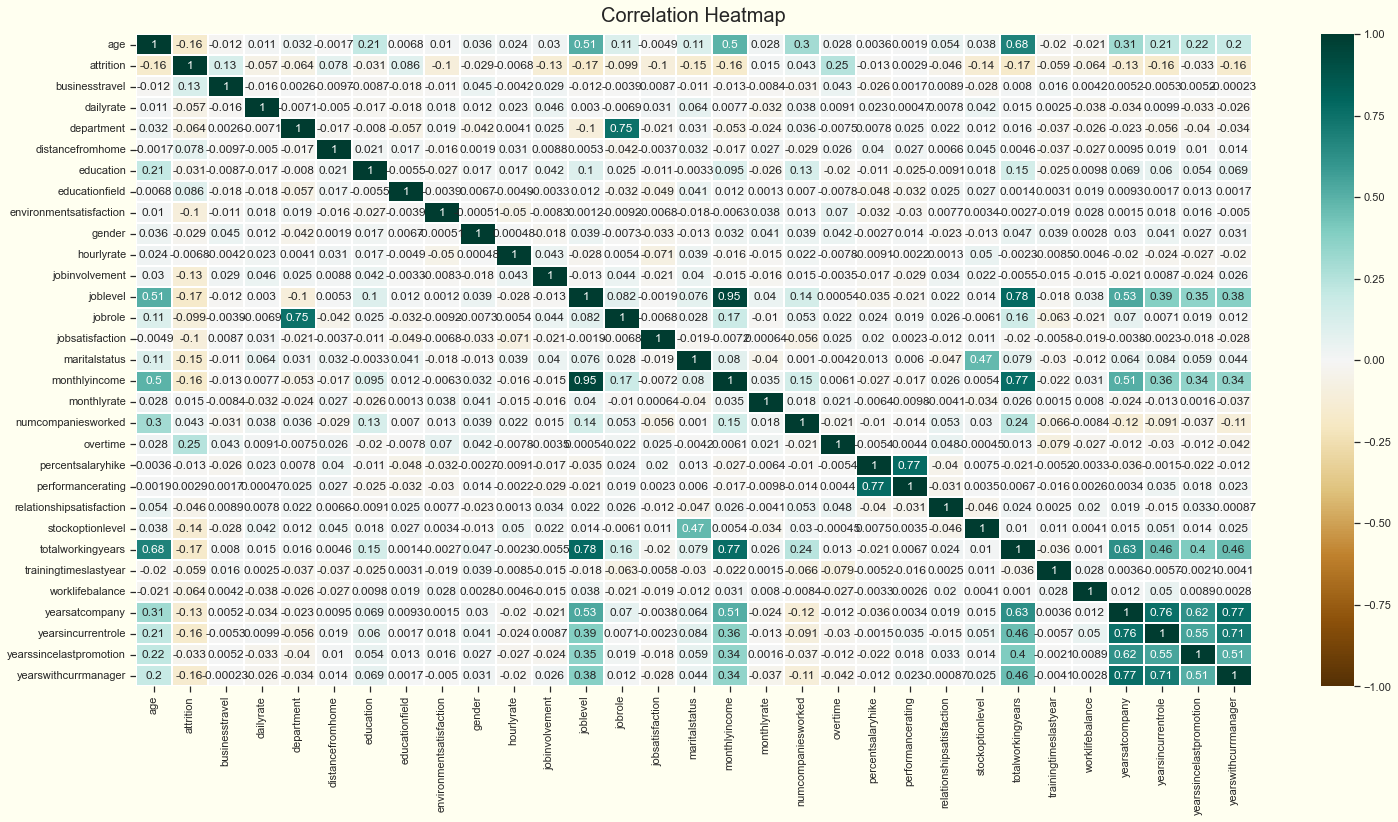

In [24]:

# Increase the size of the heatmap.
plt.figure(figsize=(25, 12))

# mask = np.triu()

# Store heatmap object in a variable.
heatmap = sns.heatmap(ibm_df_2.corr(), vmin=-1, vmax=1, annot=True, cmap='BrBG', linewidths=1)

# Set the range of values to be displayed on the colormap from -1 to 1, 
# and set the annotation to True to display the correlation values on the heatmap.
heatmap.set_title('Correlation Heatmap', fontdict={'fontsize':20}, pad=12)

# save heatmap as .png file
plt.savefig('heatmap.png', dpi=300, bbox_inches='tight')

In [25]:
# Remove the "attrition" column from the dataset
X = ibm_df_2.drop('attrition', axis = 1)
y = ibm_df_2['attrition']

In [26]:
ibm_df_2

,age,attrition,businesstravel,dailyrate,department,distancefromhome,education,educationfield,environmentsatisfaction,gender,hourlyrate,jobinvolvement,joblevel,jobrole,jobsatisfaction,maritalstatus,monthlyincome,monthlyrate,numcompaniesworked,overtime,percentsalaryhike,performancerating,relationshipsatisfaction,stockoptionlevel,totalworkingyears,trainingtimeslastyear,worklifebalance,yearsatcompany,yearsincurrentrole,yearssincelastpromotion,yearswithcurrmanager
0,41,1,1,1102,0,1,2,1,2,1,94,3,2,0,4,0,5993,19479,8,1,11,3,1,0,8,0,1,6,4,0,5
1,49,0,2,279,1,8,1,1,3,0,61,2,2,6,2,2,5130,24907,1,0,23,4,4,1,10,3,3,10,7,1,7
2,37,1,1,1373,1,2,2,0,4,0,92,2,1,2,3,0,2090,2396,6,1,15,3,2,0,7,3,3,0,0,0,0
3,33,0,2,1392,1,3,4,1,4,1,56,3,1,6,3,2,2909,23159,1,1,11,3,3,0,8,3,3,8,7,3,0
4,27,0,1,591,1,2,1,2,1,0,40,3,1,2,2,2,3468,16632,9,0,12,3,4,1,6,3,3,2,2,2,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1465,36,0,2,884,1,23,2,2,3,0,41,4,2,2,4,2,2571,12290,4,0,17,3,3,1,17,3,3,5,2,0,3
1466,39,0,1,613,1,6,1,2,4,0,42,2,3,4,1,2,9991,21457,4,0,15,3,1,1,9,5,3,7,7,1,7
1467,27,0,1,155,1,4,3,1,2,0,87,4,2,3,2,2,6142,5174,1,1,20,4,2,1,6,0,3,6,2,0,3
1468,49,0,2,1023,0,2,3,2,4,0,63,2,2,0,2,2,5390,13243,2,0,14,3,4,0,17,3,2,9,6,0,8


In [27]:
from sklearn.model_selection import train_test_split

# Split the data into X_train, X_test, y_train, y_test
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)

In [28]:
# Create a logistic regression model
from sklearn.linear_model import LogisticRegression
classifier = LogisticRegression()
classifier

LogisticRegression()

## Random Forest Classifier for Prediction

In [29]:
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier

##### Let’s first fit a random forest with default parameters to get a baseline idea of the performance


In [30]:
rf = RandomForestClassifier()
rf.fit(X_train, y_train)
# > RandomForestClassifier(bootstrap=True, class_weight=None, criterion=’gini’,
#  max_depth=None, max_features=’auto’, max_leaf_nodes=None,
#  min_impurity_split=1e-07, min_samples_leaf=1,
#  min_samples_split=2, min_weight_fraction_leaf=0.0,
#  n_estimators=10, n_jobs=1, oob_score=False, random_state=None,
#  verbose=0, warm_start=False)
y_pred = rf.predict(X_test)
print(f'Training Score: {rf.score(X_train, y_train)}')
print(f'Testing Score: {rf.score(X_test, y_test)}')

Training Score: 1.0
Testing Score: 0.8614130434782609


In [31]:
# print(y_train)

In [32]:
from sklearn.metrics import roc_curve, auc
false_positive_rate, true_positive_rate, thresholds = roc_curve(y_test, y_pred)
roc_auc = auc(false_positive_rate, true_positive_rate)
roc_auc

0.5411331725119071

##### N_estimators

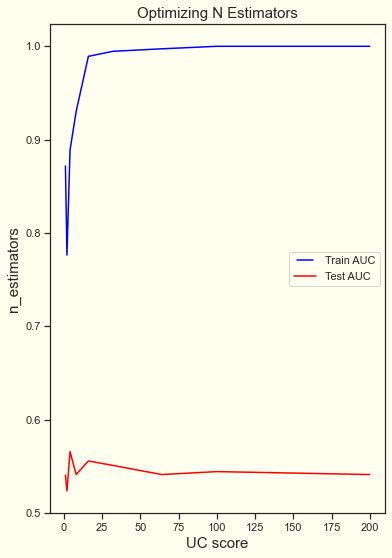

In [33]:
n_estimators = [1, 2, 4, 8, 16, 32, 64, 100, 200]
train_results = []
test_results = []
for estimator in n_estimators:
   rf = RandomForestClassifier(n_estimators=estimator, n_jobs=-1)
   rf.fit(X_train, y_train)
   train_pred = rf.predict(X_train)
   false_positive_rate, true_positive_rate, thresholds = roc_curve(y_train, train_pred)
   roc_auc = auc(false_positive_rate, true_positive_rate)
   train_results.append(roc_auc)
   y_pred = rf.predict(X_test)
   false_positive_rate, true_positive_rate, thresholds = roc_curve(y_test, y_pred)
   roc_auc = auc(false_positive_rate, true_positive_rate)
   test_results.append(roc_auc)
from matplotlib.legend_handler import HandlerLine2D
line1, = plt.plot(n_estimators, train_results, color = 'Blue', label= 'Train AUC')
line2, = plt.plot(n_estimators, test_results, color = 'Red', label= 'Test AUC')
plt.legend(handler_map={line1: HandlerLine2D(numpoints=2)})

plt.xlabel("UC score", fontsize=15)
plt.ylabel("n_estimators", fontsize=15)
plt.title('Optimizing N Estimators',fontsize=15);

plt.show()

##### we can stop at 20 trees as increasing the number of trees decreases the test performance.

##### max_depth

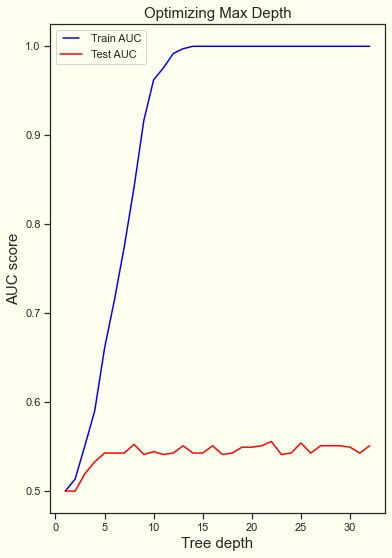

In [34]:
max_depths = np.linspace(1, 32, 32, endpoint=True)
train_results = []
test_results = []
for max_depth in max_depths:
   rf = RandomForestClassifier(max_depth=max_depth, n_jobs=-1)
   rf.fit(X_train, y_train)
   train_pred = rf.predict(X_train)
   false_positive_rate, true_positive_rate, thresholds = roc_curve(y_train, train_pred)
   roc_auc = auc(false_positive_rate, true_positive_rate)
   train_results.append(roc_auc)
   y_pred = rf.predict(X_test)
   false_positive_rate, true_positive_rate, thresholds = roc_curve(y_test, y_pred)
   roc_auc = auc(false_positive_rate, true_positive_rate)
   test_results.append(roc_auc)
from matplotlib.legend_handler import HandlerLine2D
line1, = plt.plot(max_depths, train_results, color = 'Blue', label='Train AUC')
line2, = plt.plot(max_depths, test_results, color = 'Red', label='Test AUC')
plt.legend(handler_map={line1: HandlerLine2D(numpoints=2)})
plt.ylabel("AUC score", fontsize=15)
plt.xlabel("Tree depth", fontsize=15)
plt.title('Optimizing Max Depth',fontsize=15);
plt.show()

##### Our model overfits for large depth values. The trees perfectly predicts all of the train data, however, it fails to generalize the findings for new data

##### min_samples_split

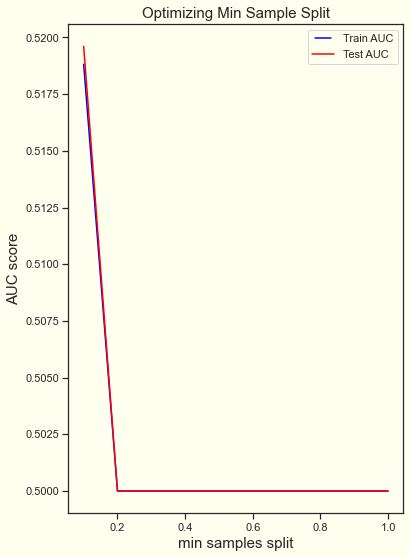

In [35]:
min_samples_splits = np.linspace(0.1, 1.0, 10, endpoint=True)
train_results = []
test_results = []
for min_samples_split in min_samples_splits:
   rf = RandomForestClassifier(min_samples_split=min_samples_split)
   rf.fit(X_train, y_train)
   train_pred = rf.predict(X_train)
   false_positive_rate, true_positive_rate, thresholds = roc_curve(y_train, train_pred)
   roc_auc = auc(false_positive_rate, true_positive_rate)
   train_results.append(roc_auc)
   y_pred = rf.predict(X_test)
   false_positive_rate, true_positive_rate, thresholds = roc_curve(y_test, y_pred)
   roc_auc = auc(false_positive_rate, true_positive_rate)
   test_results.append(roc_auc)
from matplotlib.legend_handler import HandlerLine2D
line1, = plt.plot(min_samples_splits, train_results, color = 'Blue', label= 'Train AUC')
line2, = plt.plot(min_samples_splits, test_results, color = 'Red', label= 'Test AUC')
plt.legend(handler_map={line1: HandlerLine2D(numpoints=2)})
plt.ylabel("AUC score", fontsize=15)
plt.xlabel("min samples split", fontsize=15)
plt.title('Optimizing Min Sample Split',fontsize=15);
plt.show()

##### We can clearly see that when we require all of the samples at each node, the model cannot learn enough about the data. This is an underfitting case.

##### min_samples_leaf

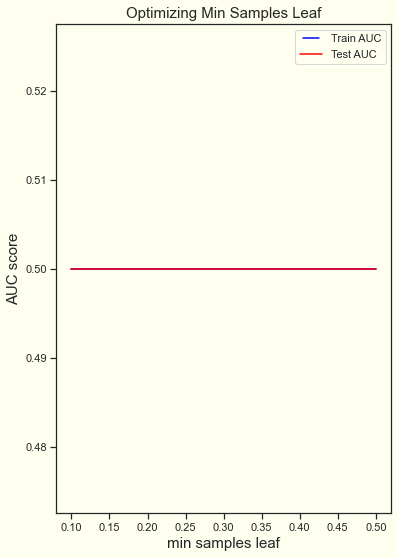

In [36]:
min_samples_leafs = np.linspace(0.1, 0.5, 5, endpoint=True)
train_results = []
test_results = []
for min_samples_leaf in min_samples_leafs:
   rf = RandomForestClassifier(min_samples_leaf=min_samples_leaf)
   rf.fit(X_train, y_train)
   train_pred = rf.predict(X_train)
   false_positive_rate, true_positive_rate, thresholds = roc_curve(y_train, train_pred)
   roc_auc = auc(false_positive_rate, true_positive_rate)
   train_results.append(roc_auc)
   y_pred = rf.predict(X_test)
   false_positive_rate, true_positive_rate, thresholds = roc_curve(y_test, y_pred)
   roc_auc = auc(false_positive_rate, true_positive_rate)
   test_results.append(roc_auc)
from matplotlib.legend_handler import HandlerLine2D
line1, = plt.plot(min_samples_leafs, train_results, color = 'Blue', label='Train AUC')
line2, = plt.plot(min_samples_leafs, test_results, color = 'Red', label='Test AUC')
plt.legend(handler_map={line1: HandlerLine2D(numpoints=2)})
plt.ylabel("AUC score",fontsize=15)
plt.xlabel("min samples leaf",fontsize=15)
plt.title('Optimizing Min Samples Leaf',fontsize=15);
plt.show()

##### Same conclusion as to previous parameter. Increasing this value can cause underfitting.

##### max_features

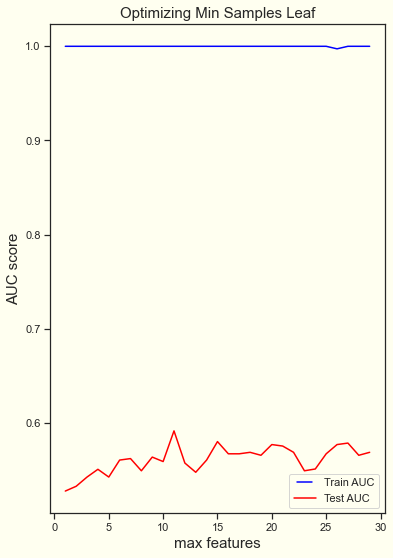

In [37]:
max_features = list(range(1,X_train.shape[1]))
train_results = []
test_results = []
for max_feature in max_features:
   rf = RandomForestClassifier(max_features=max_feature)
   rf.fit(X_train, y_train)
   train_pred = rf.predict(X_train)
   false_positive_rate, true_positive_rate, thresholds = roc_curve(y_train, train_pred)
   roc_auc = auc(false_positive_rate, true_positive_rate)
   train_results.append(roc_auc)
   y_pred = rf.predict(X_test)
   false_positive_rate, true_positive_rate, thresholds = roc_curve(y_test, y_pred)
   roc_auc = auc(false_positive_rate, true_positive_rate)
   test_results.append(roc_auc)
from matplotlib.legend_handler import HandlerLine2D
line1, = plt.plot(max_features, train_results, color = 'Blue', label='Train AUC')
line2, = plt.plot(max_features, test_results, color = 'Red', label='Test AUC')
plt.legend(handler_map={line1: HandlerLine2D(numpoints=2)})
plt.ylabel("AUC score",fontsize=15)
plt.xlabel("max features",fontsize=15)
plt.title('Optimizing Min Samples Leaf',fontsize=15);
plt.show()

##### This is also an overfitting case It’s unexpected to get overfitting for all values of max_features. However, according to sklearn documentation for random forest, the search for a split does not stop until at least one valid partition of the node samples is found, even if it requires to effectively inspect more than max_features features.

##### What Does this mean????

## ___________________________________

#### Ok Lets Do This

In [38]:
# Train a Random Forest Classifier model and print the model score (Unscaled data)
clf = RandomForestClassifier(random_state=42, n_estimators=20, max_depth=2).fit(X_train, y_train)
print(f'Training Score: {clf.score(X_train, y_train)}')
print(f'Testing Score: {clf.score(X_test, y_test)}')

Training Score: 0.8366606170598911
Testing Score: 0.8668478260869565


In [39]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import GridSearchCV

In [ ]:
X = ibm_df_2.drop('attrition', axis = 1)
y = ibm_df_2['attrition']

In [ ]:
y_aug = copy.deepcopy(attrition.values)
x_aug = copy.deepcopy(scaled_df.values)

X_train, X_test, y_train, y_test = train_test_split(x_aug, y_aug, 
                                                    stratify=attrition)

In [40]:
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

def print_score(clf, X_train, y_train, X_test, y_test, train=True):
    if train:
        pred = clf.predict(X_train)
        clf_report = pd.DataFrame(classification_report(y_train, pred, output_dict=True))
        print("Train Result:\n================================================")
        print(f"Accuracy Score: {accuracy_score(y_train, pred) * 100:.2f}%")
        print("_______________________________________________")
        print(f"CLASSIFICATION REPORT:\n{clf_report}")
        print("_______________________________________________")
        print(f"Confusion Matrix: \n {confusion_matrix(y_train, pred)}\n")
        
    elif train==False:
        pred = clf.predict(X_test)
        clf_report = pd.DataFrame(classification_report(y_test, pred, output_dict=True))
        print("Test Result:\n================================================")        
        print(f"Accuracy Score: {accuracy_score(y_test, pred) * 100:.2f}%")
        print("_______________________________________________")
        print(f"CLASSIFICATION REPORT:\n{clf_report}")
        print("_______________________________________________")
        print(f"Confusion Matrix: \n {confusion_matrix(y_test, pred)}\n")

In [41]:
n_estimators = [int(x) for x in np.linspace(start=200, stop=2000, num=10)]
max_features = ['auto', 'sqrt']
max_depth = [int(x) for x in np.linspace(10, 110, num=11)]
max_depth.append(None)
min_samples_split = [2, 5, 10]
min_samples_leaf = [1, 2, 4]
bootstrap = [True, False]

random_grid = {'n_estimators': n_estimators, 'max_features': max_features,
               'max_depth': max_depth, 'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf, 'bootstrap': bootstrap}

rf_clf = RandomForestClassifier(random_state=42)

rf_cv = RandomizedSearchCV(estimator=rf_clf, scoring='f1',param_distributions=random_grid, n_iter=100, cv=3, 
                               verbose=2, random_state=42, n_jobs=-1)

rf_cv.fit(X_train, y_train)
rf_best_params = rf_cv.best_params_
print(f"Best paramters: {rf_best_params})")

rf_clf = RandomForestClassifier(**rf_best_params)
rf_clf.fit(X_train, y_train)

print_score(rf_clf, X_train, y_train, X_test, y_test, train=True)
print_score(rf_clf, X_train, y_train, X_test, y_test, train=False)

Fitting 3 folds for each of 100 candidates, totalling 300 fits
Best paramters: {'n_estimators': 200, 'min_samples_split': 5, 'min_samples_leaf': 2, 'max_features': 'auto', 'max_depth': 90, 'bootstrap': False})
Train Result:
Accuracy Score: 100.00%
_______________________________________________
CLASSIFICATION REPORT:
               0      1  accuracy  macro avg  weighted avg
precision    1.0    1.0       1.0        1.0           1.0
recall       1.0    1.0       1.0        1.0           1.0
f1-score     1.0    1.0       1.0        1.0           1.0
support    916.0  186.0       1.0     1102.0        1102.0
_______________________________________________
Confusion Matrix: 
 [[916   0]
 [  0 186]]

Test Result:
Accuracy Score: 86.68%
_______________________________________________
CLASSIFICATION REPORT:
                    0          1  accuracy   macro avg  weighted avg
precision    0.874302   0.600000  0.866848    0.737151      0.836287
recall       0.987382   0.117647  0.866848    0.5

In [42]:
n_estimators = [100, 500, 1000, 1500]
max_features = ['auto', 'sqrt']
max_depth = [2, 3, 5]
max_depth.append(None)
min_samples_split = [2, 5, 10]
min_samples_leaf = [1, 2, 4, 10]
bootstrap = [True, False]

params_grid = {'n_estimators': n_estimators, 'max_features': max_features,
               'max_depth': max_depth, 'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf, 'bootstrap': bootstrap}

rf_clf = RandomForestClassifier(random_state=42)

rf_cv = GridSearchCV(rf_clf, params_grid, scoring="f1", cv=3, verbose=2, n_jobs=-1)


rf_cv.fit(X_train, y_train)
best_params = rf_cv.best_params_
print(f"Best parameters: {best_params}")

rf_clf = RandomForestClassifier(**best_params)
rf_clf.fit(X_train, y_train)

print_score(rf_clf, X_train, y_train, X_test, y_test, train=True)
print_score(rf_clf, X_train, y_train, X_test, y_test, train=False)

Fitting 3 folds for each of 768 candidates, totalling 2304 fits
Best parameters: {'bootstrap': False, 'max_depth': None, 'max_features': 'auto', 'min_samples_leaf': 1, 'min_samples_split': 10, 'n_estimators': 500}
Train Result:
Accuracy Score: 99.46%
_______________________________________________
CLASSIFICATION REPORT:
                    0           1  accuracy    macro avg  weighted avg
precision    0.993492    1.000000  0.994555     0.996746      0.994591
recall       1.000000    0.967742  0.994555     0.983871      0.994555
f1-score     0.996736    0.983607  0.994555     0.990171      0.994520
support    916.000000  186.000000  0.994555  1102.000000   1102.000000
_______________________________________________
Confusion Matrix: 
 [[916   0]
 [  6 180]]

Test Result:
Accuracy Score: 85.87%
_______________________________________________
CLASSIFICATION REPORT:
                    0          1  accuracy   macro avg  weighted avg
precision    0.873239   0.461538  0.858696    0.667389 

In [56]:
from imblearn import under_sampling, over_sampling
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline


In [61]:
y_aug = copy.deepcopy(y.values)
X_aug = copy.deepcopy(X.values)

X_train, X_test, y_train, y_test = train_test_split(X_aug, y_aug, 
                                                    stratify=y)


Counter({0: 924, 1: 178})



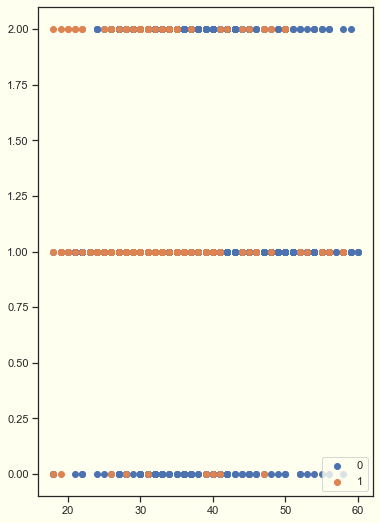

In [66]:
# Adopted parts of code from Brownlee, J. (2020).

# Class distribution summary
counter = Counter(y_train)
print(counter)
print()

# scatter plot of examples by class label
for label, _ in counter.items():
	row_ix = where(y_train == label)[0]
	plt.scatter(X_train[row_ix, 0], X_train[row_ix, 1], label=str(label))
plt.legend()
plt.show()
